In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn.model_selection import  KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score,roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../Data/gppp.csv').set_index('cod_scu_anonimo')
data = data[(data.Fattore_correzione > 0.85)]
data['miglioramento_mate'] = (data.improv_mate_diff_mean > np.quantile(data.improv_mate_diff_mean.dropna(), 0.5)).apply(int)
data.describe()

,opinione_invalsi,utilizzo_invalsi,discussi_insegnanti,discussi_genitori,sodd_pon,attivita_preside,pressioni_genitori,coinvolgimento_genitori_prop,opinione_associazioni_genitori,coinvolgimento_genitori_eff,condotta_studenti,registro_elettronico,numero_plessi,infrastrutture,strumenti,preside_maschio,eta_preside,voto_scritto_ita,voto_scritto_mat,voto_scritto_ita_cont,voto_scritto_mat_cont,Pon,Fattore_correzione,statale,paritaria,Nord,Centro,Sud,school_score_ita,school_score_mate,school_escs,class_tot,class_fem,prop_fem,class_imm1,prop_imm1,class_imm2,prop_imm2,class_late,prop_late,public,voto_orale_ita_mean,voto_orale_ita_std,voto_orale_ita_skew,voto_orale_ita_min,voto_orale_ita_max,voto_orale_ita_median,voto_orale_ita_q25,voto_orale_ita_q75,voto_orale_mat_mean,voto_orale_mat_std,voto_orale_mat_skew,voto_orale_mat_min,voto_orale_mat_max,voto_orale_mat_median,voto_orale_mat_q25,voto_orale_mat_q75,voto_orale_ita_cont_mean,voto_orale_ita_cont_std,voto_orale_ita_cont_skew,voto_orale_ita_cont_min,voto_orale_ita_cont_max,voto_orale_ita_cont_median,voto_orale_ita_cont_q25,voto_orale_ita_cont_q75,voto_orale_mat_cont_mean,voto_orale_mat_cont_std,voto_orale_mat_cont_skew,voto_orale_mat_cont_min,voto_orale_mat_cont_max,voto_orale_mat_cont_median,voto_orale_mat_cont_q25,voto_orale_mat_cont_q75,pu_ma_gr_mean,pu_ma_gr_std,pu_ma_gr_skew,pu_ma_gr_min,pu_ma_gr_max,pu_ma_gr_median,pu_ma_gr_q25,pu_ma_gr_q75,pu_ma_no_mean,pu_ma_no_std,pu_ma_no_skew,pu_ma_no_min,pu_ma_no_max,pu_ma_no_median,pu_ma_no_q25,pu_ma_no_q75,part_1_gr_mean,part_1_gr_std,part_1_gr_skew,part_1_gr_min,part_1_gr_max,part_1_gr_median,part_1_gr_q25,part_1_gr_q75,part_1_no_mean,part_1_no_std,part_1_no_skew,part_1_no_min,part_1_no_max,part_1_no_median,part_1_no_q25,part_1_no_q75,part_2_gr_mean,part_2_gr_std,part_2_gr_skew,part_2_gr_min,part_2_gr_max,part_2_gr_median,part_2_gr_q25,part_2_gr_q75,part_2_no_mean,part_2_no_std,part_2_no_skew,part_2_no_min,part_2_no_max,part_2_no_median,part_2_no_q25,part_2_no_q75,part_3_gr_mean,part_3_gr_std,part_3_gr_skew,part_3_gr_min,part_3_gr_max,part_3_gr_median,part_3_gr_q25,part_3_gr_q75,part_3_no_mean,part_3_no_std,part_3_no_skew,part_3_no_min,part_3_no_max,part_3_no_median,part_3_no_q25,part_3_no_q75,part_4_gr_mean,part_4_gr_std,part_4_gr_skew,part_4_gr_min,part_4_gr_max,part_4_gr_median,part_4_gr_q25,part_4_gr_q75,part_4_no_mean,part_4_no_std,part_4_no_skew,part_4_no_min,part_4_no_max,part_4_no_median,part_4_no_q25,part_4_no_q75,proc_1_gr_mean,proc_1_gr_std,proc_1_gr_skew,proc_1_gr_min,proc_1_gr_max,proc_1_gr_median,proc_1_gr_q25,proc_1_gr_q75,proc_2_gr_mean,proc_2_gr_std,proc_2_gr_skew,proc_2_gr_min,proc_2_gr_max,proc_2_gr_median,proc_2_gr_q25,proc_2_gr_q75,proc_3_gr_mean,proc_3_gr_std,proc_3_gr_skew,proc_3_gr_min,proc_3_gr_max,proc_3_gr_median,proc_3_gr_q25,proc_3_gr_q75,proc_1_no_mean,proc_1_no_std,proc_1_no_skew,proc_1_no_min,proc_1_no_max,proc_1_no_median,proc_1_no_q25,proc_1_no_q75,proc_2_no_mean,proc_2_no_std,proc_2_no_skew,proc_2_no_min,proc_2_no_max,proc_2_no_median,proc_2_no_q25,proc_2_no_q75,proc_3_no_mean,proc_3_no_std,proc_3_no_skew,proc_3_no_min,proc_3_no_max,proc_3_no_median,proc_3_no_q25,proc_3_no_q75,WLE_MAT_200_mean,WLE_MAT_200_std,WLE_MAT_200_skew,WLE_MAT_200_min,WLE_MAT_200_max,WLE_MAT_200_median,WLE_MAT_200_q25,WLE_MAT_200_q75,WLE_MAT_200_CORR_mean,WLE_MAT_200_CORR_std,WLE_MAT_200_CORR_skew,WLE_MAT_200_CORR_min,WLE_MAT_200_CORR_max,WLE_MAT_200_CORR_median,WLE_MAT_200_CORR_q25,WLE_MAT_200_CORR_q75,mate8_mean,mate8_std,mate8_skew,mate8_min,mate8_max,mate8_median,mate8_q25,mate8_q75,pu_it_gr_mean,pu_it_gr_std,pu_it_gr_skew,pu_it_gr_min,pu_it_gr_max,pu_it_gr_median,pu_it_gr_q25,pu_it_gr_q75,pu_it_no_mean,pu_it_no_std,pu_it_no_skew,pu_it_no_min,pu_it_no_max,pu_it_no_median,pu_it_no_q25,pu_it_no_q75,WLE_ITA_200_mean,WLE_ITA_200_std,WLE_ITA_200_skew,WLE_ITA_200_min,WLE_ITA_200_max,WLE_ITA_200_median,WLE_ITA_200_q25,WLE_ITA_200_q75,WLE_ITA_200_CORR_mean,WLE_ITA_200_CORR_std,WLE_ITA_200_CORR_skew,WLE_ITA_200_CORR_min,WLE_ITA_200_COR

In [3]:
seed = 10962
label = 'miglioramento_mate'
cols = ['opinione_invalsi',
         'utilizzo_invalsi',
         'discussi_insegnanti',
         'discussi_genitori',
         'attivita_preside',
         'pressioni_genitori',
         #'coinvolgimento_genitori_prop',
         #'opinione_associazioni_genitori',
         #'coinvolgimento_genitori_eff',
         #'condotta_studenti',
         #'registro_elettronico',
         'numero_plessi',
         'infrastrutture',
         'strumenti',
         #'preside_maschio',
         'eta_preside',
         #'prop_maschi',
         'prop_laurea_padre',
         'prop_laurea_madre',
         'prop_diploma_padre',
         'prop_diploma_madre',
         'prop_padre_ita',
         'prop_madre_ita',
         'prop_padre_disocc',
         'prop_madre_disocc',
         'prop_bocciati',
         'mate6_mean',
         'ita6_mean',
         'Pon',
         'Sud',
         'Centro',
         'Nord',
         'ESCS_mean',
        
         label]

X = data[cols].dropna()
y = X[label]
X.drop(label,axis=1,inplace=True)

X.shape, y.shape

((392, 26), (392,))

c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gianm\appdata\local\programs\python\python38\l

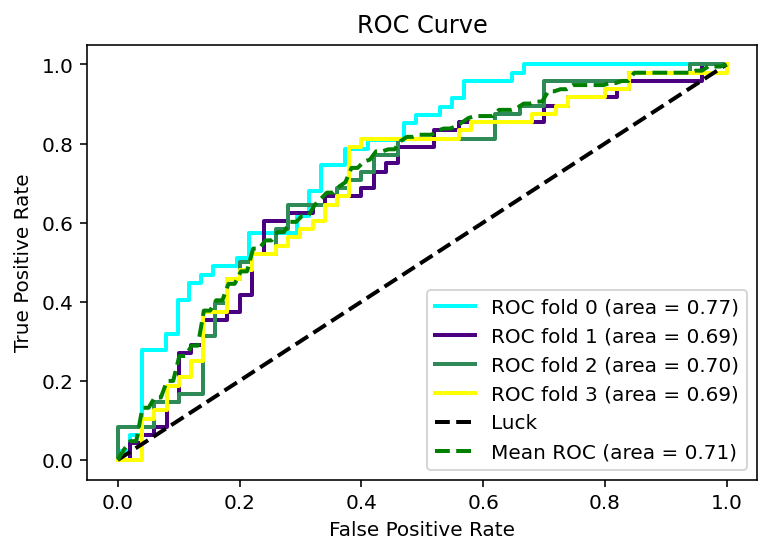

In [4]:
n_splits = 4
cv = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = seed)
    
t = time.time()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
senss = []
accs = []
rec = []
for (train, test), color in zip(cv.split(X,y), colors):
    sens = []
    acc = []
    thresh = []

    classifier = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1)

    cl = classifier.fit(X.iloc[train], y.iloc[train])
    probas_ = cl.predict_proba(X.iloc[test])
    for j in np.linspace(0,1, 1000):
        thresh.append(j)
        sens.append(recall_score((probas_[:,0]<j).astype(int),y.iloc[test])) 
        acc.append(accuracy_score((probas_[:,0]<j).astype(int), y.iloc[test]))
        preds = np.zeros(len(test))
        preds[np.argsort(-probas_[:,1])[:int(0.2*len(test))]] = 1
        rec.append(recall_score(preds,y.iloc[test]))
    
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    senss.append(sens)
    accs.append(acc)

    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

senss = np.array(senss)
accs = np.array(accs)


In [5]:
opt = 0 
for i in range(len(thresh)):
    metric =  np.mean(senss[:,i] + accs[:,i])
    if metric > opt:
        opt = metric
        opt_ind = i

print("Threshold :", round(thresh[opt_ind],4))
print("Sensitivity :", round(np.mean(senss[:,opt_ind]),4))
print("Accuracy :", round(np.mean(accs[:,opt_ind]),4))
print("Sensitivity std :", round(np.std(senss[:,opt_ind]),4))
print("Accuracy std :", round(np.std(accs[:,opt_ind]),4))
print("Recall@20 :", round(np.mean(rec),4))
print("Recall@20 std :", round(np.std(rec),4))

Threshold : 0.4034
Sensitivity : 0.695
Accuracy : 0.6454
Sensitivity std : 0.0111
Accuracy std : 0.0363
Recall@20 : 0.6842
Recall@20 std : 0.0645


In [6]:
import random
random.seed(seed)
np.random.seed(seed)

def HillClimbing(number_of_variables,number_of_evaluations,evaluation_function, verbose = True):

    # current evaluation
    evaluations = 0
    
    # start from a random set of features
    current_feature_subset = [np.random.choice(2, p=[0,1]) for x in range(number_of_variables)]

    # that will also provide an initial evaluation of the best performance
    best_performance = evaluation_function(current_feature_subset)
    if verbose :
        print("%5d\t\t%3.2f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))
    
    # continue until all the evaluations have been performed
    search = 0.2 * number_of_evaluations
    while evaluations< search:
        perturbation = [np.random.choice(2, p=[0.8, 0.2]) for x in range(number_of_variables)]
        performance = evaluation_function(perturbation)

        if (performance>best_performance):
            best_performance = performance
            current_feature_subset = perturbation

        evaluations = evaluations + 1
        if verbose:
            print("%5d\t\t%3.4f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))
        
    while evaluations < number_of_evaluations:
        
        # generate a neighbor candidate using a 10% perturbation of the current subset
        perturbation = [(lambda x: 1-x if (random.random()<0.2) else x)(x) for x in current_feature_subset]

        # evaluate only if there is at least one variable
        if (sum(perturbation)>0):
            performance = evaluation_function(perturbation)

            if (performance>best_performance):
                best_performance = performance
                current_feature_subset = perturbation

        evaluations = evaluations + 1
        if verbose:
            print("%5d\t\t%3.4f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))

    return current_feature_subset, best_performance

In [7]:
def run(subset):
    
    t = time.time()
    sel = [bool(x) for x in subset]
    X_tr = X[X.columns[sel]]

    AUC = []
    for (train, test) in cv.split(X_tr,y):
        thresh = []
        classifier = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1)
        cl = classifier.fit(X_tr.iloc[train], y.iloc[train])
        probas_ = cl.predict_proba(X_tr.iloc[test])
        preds = np.zeros(len(test))
        preds[np.argsort(-probas_[:,1])[:int(0.2*len(test))]] = 1
        AUC.append(roc_auc_score(preds,y.iloc[test]))

    print("AUC :", round(np.mean(AUC),4))
    print("AUC std :", round(np.std(AUC),4))
    
    
    return round(np.mean(AUC),4) - 5e-4*sum(subset) - round(np.std(AUC),4)


In [8]:
HillClimbing(X.shape[1],200,run, verbose = True)

AUC : 0.6222
AUC std : 0.0426
    0		0.57	Index(['opinione_invalsi', 'utilizzo_invalsi', 'discussi_insegnanti',
       'discussi_genitori', 'attivita_preside', 'pressioni_genitori',
       'numero_plessi', 'infrastrutture', 'strumenti', 'eta_preside',
       'prop_laurea_padre', 'prop_laurea_madre', 'prop_diploma_padre',
       'prop_diploma_madre', 'prop_padre_ita', 'prop_madre_ita',
       'prop_padre_disocc', 'prop_madre_disocc', 'prop_bocciati', 'mate6_mean',
       'ita6_mean', 'Pon', 'Sud', 'Centro', 'Nord', 'ESCS_mean'],
      dtype='object')
AUC : 0.6793
AUC std : 0.0759
    1		0.6024	Index(['numero_plessi', 'mate6_mean'], dtype='object')
AUC : 0.663
AUC std : 0.0381
    2		0.6219	Index(['attivita_preside', 'pressioni_genitori', 'infrastrutture', 'strumenti',
       'eta_preside', 'mate6_mean'],
      dtype='object')
AUC : 0.5406
AUC std : 0.0864
    3		0.6219	Index(['attivita_preside', 'pressioni_genitori', 'infrastrutture', 'strumenti',
       'eta_preside', 'mate6_mean'],
  

AUC : 0.6548
AUC std : 0.0575
   54		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.5406
AUC std : 0.0387
   55		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6711
AUC std : 0.018
   56		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6711
AUC std : 0.0344
   57		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6793
AUC std : 0.0646
   58		0.6649	Index(['opinione_invalsi', 'discussi_genitori

AUC : 0.4998
AUC std : 0.0381
   90		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6711
AUC std : 0.0611
   91		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6711
AUC std : 0.0565
   92		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6548
AUC std : 0.0484
   93		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6793
AUC std : 0.0374
   94		0.6649	Index(['opinione_invalsi', 'discussi_genitor

AUC : 0.6467
AUC std : 0.0507
  126		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.5242
AUC std : 0.0773
  127		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.4998
AUC std : 0.0286
  128		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6548
AUC std : 0.0426
  129		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.663
AUC std : 0.0446
  130		0.6649	Index(['opinione_invalsi', 'discussi_genitori

AUC : 0.6875
AUC std : 0.0537
  162		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.663
AUC std : 0.0353
  163		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.5161
AUC std : 0.0646
  164		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.5569
AUC std : 0.0374
  165		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6303
AUC std : 0.0434
  166		0.6649	Index(['opinione_invalsi', 'discussi_genitori

AUC : 0.6303
AUC std : 0.0798
  198		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6875
AUC std : 0.0232
  199		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')
AUC : 0.6711
AUC std : 0.018
  200		0.6649	Index(['opinione_invalsi', 'discussi_genitori', 'pressioni_genitori',
       'infrastrutture', 'prop_laurea_padre', 'prop_bocciati', 'mate6_mean',
       'Pon'],
      dtype='object')


([1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0],
 0.6649)

In [9]:
#subset = [0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,0]
subset = [1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0]
sel = [bool(x) for x in subset]
X = X[X.columns[sel]]

c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

c:\users\gianm\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero

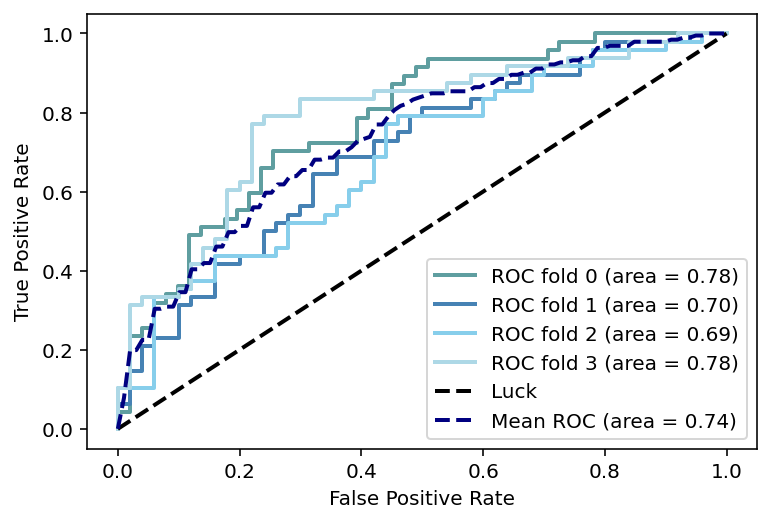

In [28]:
n_splits = 4
cv = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = seed)
    
t = time.time()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cadetblue', 'steelblue', 'skyblue', 'lightblue', 'blue', 'midnightblue'])
lw = 2

i = 0
senss = []
accs = []
rec = []
aucs = []
for (train, test), color in zip(cv.split(X,y), colors):
    sens = []
    acc = []
    thresh = []

    classifier = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1, interactions = 10)

    cl = classifier.fit(X.iloc[train], y.iloc[train])
    probas_ = cl.predict_proba(X.iloc[test])
    for j in np.linspace(0,1, 1000):
        thresh.append(j)
        sens.append(recall_score((probas_[:,0]<j).astype(int),y.iloc[test])) 
        acc.append(accuracy_score((probas_[:,0]<j).astype(int), y.iloc[test]))
        preds = np.zeros(len(test))
        preds[np.argsort(-probas_[:,1])[:int(0.2*len(test))]] = 1
        rec.append(recall_score(preds,y.iloc[test]))
    
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    senss.append(sens)
    accs.append(acc)

    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='navy', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Math Improvement Classification')
plt.legend(loc="lower right")
plt.show()

senss = np.array(senss)
accs = np.array(accs)


In [31]:
np.std(aucs)

0.04541440405787467

In [15]:
opt = 0 
for i in range(len(thresh)):
    metric =  np.mean(senss[:,i] + accs[:,i])
    if metric > opt:
        opt = metric
        opt_ind = i

print("Threshold :", round(thresh[opt_ind],4))
print("Sensitivity :", round(np.mean(senss[:,opt_ind]),4))
print("Accuracy :", round(np.mean(accs[:,opt_ind]),4))
print("Sensitivity std :", round(np.std(senss[:,opt_ind]),4))
print("Accuracy std :", round(np.std(accs[:,opt_ind]),4))
print("Recall@20 :", round(np.mean(rec),4))
print("Recall@20 std :", round(np.std(rec),4))

Threshold : 0.2102
Sensitivity : 0.9295
Accuracy : 0.574
Sensitivity std : 0.0762
Accuracy std : 0.0196
Recall@20 : 0.8026
Recall@20 std : 0.0436


In [16]:
from interpret import show

ebm_global = cl.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2836726902160/ -->

In [26]:
?ebm_global